# Rule 1: Load and inspect data
This rule loads and inspects the dataset, converts timestamp fields, and identifies users with more than 5 transactions in any given hour.


In [1492]:
import pandas as pd
df = pd.read_csv("../data/fraud_detection_transactions.csv")
df.head()

,transaction_id,user_id,amount,timestamp,city,merchant_id,refund_flag,device_id,ip_address
0,4c5fe327-6ce7-4d78-be82-1a534701bab2,1418,4564.12,2024-10-29 11:20:33,Latashafort,0fac5605-0745-4a3f-82fc-cfdb7aa4d715,0,286c9591-6ca1-4faf-881d-a48a66115876,223.49.188.182
1,4bb57621-eab2-463d-b07a-b7c2d0cdeb8c,4824,249.24,2024-10-29 11:29:00,Cruzchester,1cdf9dab-aabf-47dd-8c67-0b41e8ff6cc9,0,21915fa0-0ec2-4e00-a4bc-28afc71cc5bd,197.65.53.245
2,b829e887-edb5-4c8f-8e5e-f4fc79efe534,1205,1111.49,2024-10-29 11:33:12,Whitneyberg,ffc2965d-71e9-4a06-b7fc-d02325422e9b,0,464d1ee0-6c21-42f0-b7aa-736c85d859f2,140.151.1.164
3,67d521f7-5c15-4175-8970-2cd1d6c04bc0,4445,2097.22,2024-10-29 11:40:19,East John,dd4f2231-9b8b-4568-b723-01ef6878288d,0,2ff64fab-ebde-4fe7-a8f7-53eece1703e6,32.228.178.27
4,cc8a9906-89b0-4b07-a7fa-d9e1498c2254,2085,3815.87,2024-10-29 11:45:28,Allenbury,ac084b11-7bdc-42da-a1c9-a14d60f662e9,0,79225e0f-9ff7-429a-bbbc-d9f6cd729156,38.166.176.127


In [1493]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  30000 non-null  object 
 1   user_id         30000 non-null  int64  
 2   amount          30000 non-null  float64
 3   timestamp       30000 non-null  object 
 4   city            30000 non-null  object 
 5   merchant_id     30000 non-null  object 
 6   refund_flag     30000 non-null  int64  
 7   device_id       30000 non-null  object 
 8   ip_address      30000 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [1494]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [1495]:
df['hour'] = df['timestamp'].dt.hour  

In [1496]:
df['txn_hour'] = df['timestamp'].dt.floor('h') 

In [1497]:
df['hour'].value_counts().sort_index()

hour
0     1269
1     1175
2     1287
3     1291
4     1256
5     1219
6     1203
7     1286
8     1273
9     1246
10    1288
11    1190
12    1267
13    1221
14    1183
15    1195
16    1278
17    1211
18    1245
19    1277
20    1273
21    1307
22    1319
23    1241
Name: count, dtype: int64

In [1498]:
txn_counts = df.groupby(['user_id', 'txn_hour']).size().reset_index(name='txn_count')
high_freq_users = txn_counts[txn_counts['txn_count'] > 5]

In [1499]:
df = df.merge(high_freq_users[['user_id', 'txn_hour']], on=['user_id', 'txn_hour'], how='left', indicator=True)
df['high_freq_flag'] = (df['_merge'] == 'both').astype(int)
df.drop('_merge', axis=1, inplace=True)

In [1500]:
df['user_id'].value_counts().head(10)

user_id
5993    11
8059    11
7905    11
8004    11
9300    11
2466    10
4062    10
5579    10
6271    10
8576    10
Name: count, dtype: int64

In [1501]:
df[df['refund_flag'] == 1].head()

,transaction_id,user_id,amount,timestamp,city,merchant_id,refund_flag,device_id,ip_address,hour,txn_hour,high_freq_flag
36,ab081b8b-c5da-4c28-8725-2fbb0bade9a3,7954,4641.00,2024-10-29 16:06:52,Prestonshire,e05f615b-ab03-40cb-83bb-256a345d47bb,1,d96c7b20-42ec-4425-90b5-dbb35559b7c0,101.69.35.130,16,2024-10-29 16:00:00,0
39,3c880092-632c-4b7f-a9e9-22a45c031d8d,3069,1787.61,2024-10-29 16:39:04,Weaverton,feb31818-fd49-4b16-8d86-060485f3e426,1,9267dddb-44a9-4d57-92a6-01c9c323547c,190.32.46.141,16,2024-10-29 16:00:00,0
51,fb728f49-07d3-4a33-a526-4ccb2bc45389,4534,1494.25,2024-10-29 18:04:11,Brightborough,082415ed-8bd0-4eff-a3f7-b08002587eac,1,71a0ef2d-d564-45fd-b4c6-8a093ddfb74f,44.85.227.255,18,2024-10-29 18:00:00,0
53,56f2daa5-520c-4556-acf6-6af265cb060b,7872,2903.93,2024-10-29 18:22:28,Kingbury,5869b740-3dee-4a02-aeb4-83dedd17b2ef,1,4342b6c7-a3b4-408a-9a65-bd8adae29b3f,3.229.183.245,18,2024-10-29 18:00:00,0
62,9f8ca46c-f2bf-4623-9c7e-71828ea5e2fe,4673,160.66,2024-10-29 19:37:22,Russellville,75829654-c313-44ba-bc82-97c43fece336,1,256421c7-470d-43c5-a511-b398660b5f3f,79.172.124.145,19,2024-10-29 19:00:00,0


In [1502]:
df[df['high_freq_flag'] == 1].to_csv("../data/high_frequency_users.csv", index=False)

# Rule 2: Transactions between 2AM-4AM

In [1503]:
import sqlite3

df['timestamp'] = pd.to_datetime(df['timestamp'])  

In [1504]:
# connect to sqlite
conn = sqlite3.connect("../sql/fraud_detection.db")

# save dataframe to table named 'transactions'
df.to_sql('transactions', conn, if_exists='replace', index=False)

30000

In [1505]:
# SQL: find odd-hour activity
query = """
SELECT *
FROM transactions
WHERE CAST(strftime('%H', timestamp) AS INTEGER) BETWEEN 2 AND 4
"""

unusual_time_df = pd.read_sql_query(query, conn)
unusual_time_df.head()


,transaction_id,user_id,amount,timestamp,city,merchant_id,refund_flag,device_id,ip_address,hour,txn_hour,high_freq_flag
0,4cc3cf9b-4e58-499e-b9b4-6d971b7740ca,8924,3718.93,2024-10-30 02:00:24,Gatesport,04bdaac1-8944-4db7-95d9-4ce8a17157d1,0,aa9c3270-2ffc-4c09-a9c3-4ef68543321e,193.57.14.4,2,2024-10-30 02:00:00,0
1,40136a9a-cd26-452e-91e0-fc338dab9990,1323,4180.20,2024-10-30 02:13:11,Josephmouth,fefd20f7-3eae-4604-bdfa-537d4d37e4a1,0,2e8d4947-83c3-4944-ab1a-5da90b72311b,71.134.231.81,2,2024-10-30 02:00:00,0
2,41f0dd83-f71b-4e79-a7d1-38c074a5502f,2301,2743.46,2024-10-30 02:17:13,Austinchester,2c5e38cb-ee4f-414b-a9c4-50735b123cf3,0,3e74126c-3063-4854-a3e7-e369d8ea9b41,173.99.247.135,2,2024-10-30 02:00:00,0
3,dafa566b-e961-4ab6-979a-38a225dbf373,3852,4554.80,2024-10-30 02:28:10,Casestad,ed701bb2-9a00-4fa3-8fda-fc4e428cc661,0,8ed71505-5323-495a-a157-90b998f3b461,170.57.47.74,2,2024-10-30 02:00:00,0
4,65b8e1fd-79b8-4bd3-bf51-ed68c61bb18e,8564,1566.59,2024-10-30 02:42:29,Port Dwayneshire,8604cd4b-40fe-4be6-a12b-fb68cf1ce311,0,18bec6a9-4b7c-458e-af8c-a55601b980a5,149.174.232.205,2,2024-10-30 02:00:00,0


In [1506]:
unusual_time_df.to_csv("../data/unusual_time_transactions.csv", index=False)

In [1507]:
len(unusual_time_df), unusual_time_df['user_id'].nunique()


(3834, 3119)

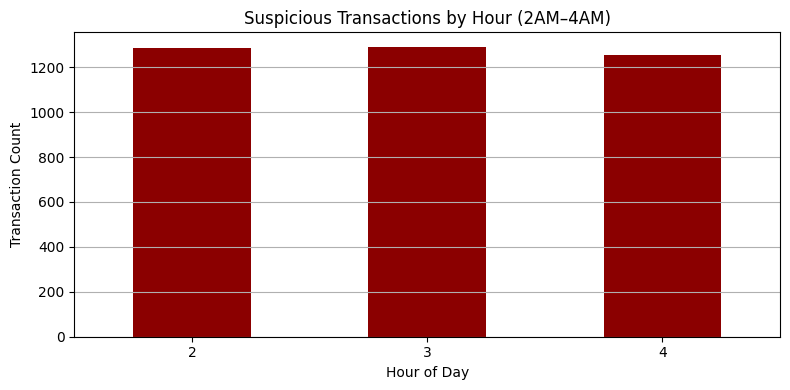

In [1508]:
import matplotlib.pyplot as plt

# extracting hour from timestamp
unusual_time_df['hour'] = pd.to_datetime(unusual_time_df['timestamp']).dt.hour

# plot frequency of transactions p/hour
unusual_time_df['hour'].value_counts().sort_index().plot(
    kind='bar',
    color='darkred',
    figsize=(8, 4)
)

plt.title("Suspicious Transactions by Hour (2AM–4AM)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Chart insight:**  
this bar chart shows transaction volume during the flagged 2am–4am window.  
consistent activity at these hours may suggest automated or bot-driven behavior, especially if combined with other fraud indicators such as high frequency or shared devices.

# Rule 3: Refund heavy users detection

In [1509]:
df['month'] = pd.to_datetime(df['timestamp']).dt.to_period('M')

In [1510]:
refunds_by_user_month = df[df['refund_flag'] == 1] \
    .groupby(['user_id', 'month']) \
    .size() \
    .reset_index(name='refund_count')

In [1511]:
refund_heavy_users = refunds_by_user_month[refunds_by_user_month['refund_count'] > 3]
refund_heavy_users.head()

,user_id,month,refund_count


In [1512]:
df = df.merge(
    refund_heavy_users[['user_id', 'month']],
    on=['user_id', 'month'],
    how='left',
    indicator=True
)
df['refund_heavy_flag'] = (df['_merge'] == 'both').astype(int)
df.drop(columns=['_merge'], inplace=True)

In [1513]:
df[df['refund_heavy_flag'] == 1].to_csv("../data/refund_heavy_users.csv", index=False)

##Rule 4: Shared device usage,
This rule flags device IDs used by 5 or more unique users. 
Frequent users sharing on the same device indicate account farming, collusion or system abuse.

In [1514]:
shared_devices = df.groupby('device_id')['user_id'].nunique().reset_index(name='user_count')

In [1515]:
abused_devices = shared_devices[shared_devices['user_count'] >= 5]
abused_devices.head()

,device_id,user_count


In [1516]:
df = df.merge(abused_devices[['device_id']], on='device_id', how='left', indicator=True)
df['shared_device_flag'] = (df['_merge'] == 'both').astype(int)
df.drop(columns=['_merge'], inplace=True)

In [1517]:
df[df['shared_device_flag'] == 1].to_csv("../data/shared_device_users.csv", index=False)

In [1518]:
print(f"Flagged {df['shared_device_flag'].sum()} transactions from shared devices used by 5+ users.")

Flagged 0 transactions from shared devices used by 5+ users.


# Fraud Rule 5- high transaction amount spikes
Objective: detect individual transactions in which are 3x larger than their average (potential sign of credential abuse or test of stolen cards)

In [1519]:
user_avg = df.groupby('user_id')['amount'].mean().reset_index(name='avg_amount')
df = df.merge(user_avg, on='user_id')

In [1520]:
df['amount_spike_flag'] = (df['amount'] > 3 * df['avg_amount']).astype(int)

In [1521]:
df[df['amount_spike_flag'] == 1].to_csv("../data/amount_spike_users.csv", index=False)

In [1522]:
print(f"Flagged {df['amount_spike_flag'].sum()} high-spike transactions.")

Flagged 24 high-spike transactions.


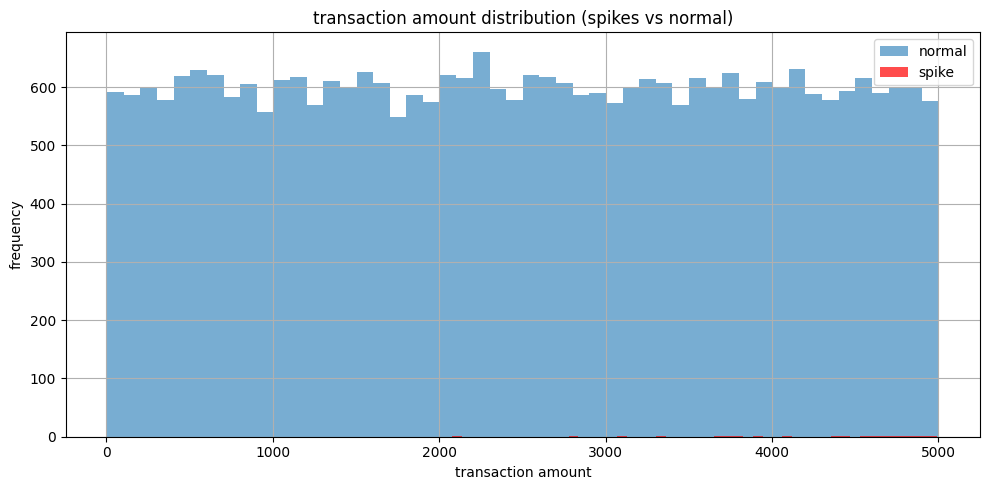

In [1523]:
import matplotlib.pyplot as plt

# compare flagged spikes vs non-spikes
plt.figure(figsize=(10, 5))
plt.hist(df[df['amount_spike_flag'] == 0]['amount'], bins=50, alpha=0.6, label='normal')
plt.hist(df[df['amount_spike_flag'] == 1]['amount'], bins=50, alpha=0.7, label='spike', color='red')
plt.xlabel("transaction amount")
plt.ylabel("frequency")
plt.title("transaction amount distribution (spikes vs normal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Chart insight:**  
spike transactions (in red) show up far to the right of the normal range, supporting the fraud logic behind rule #5.

# Rule 6: Assign Risk Scores  
Objective: Calculate a composite fraud risk score based on key behavioral indicators.

In [1524]:
df['risk_score'] = (
    (df['hour'].isin([2, 3, 4]) * 2) +               # unusual transaction hours
    (df['refund_flag'] * 3) +                        # refund activity
    (df['amount'] > 1000).astype(int) * 2 +          # large transactions
    (df['shared_device_flag'] * 2) +                 # shared device use
    (df['high_freq_flag'] * 3) +                     # high frequency activity
    (df['amount_spike_flag'] * 2)                    # sudden spikes
)

In [1525]:
high_risk = df[df['risk_score'] >= 5]

In [ ]:
import os 
print(os.getcwd())


c:\Users\test123\Desktop\fraud_detection_project\notebooks


In [1527]:
high_risk.to_csv("../data/high_risk_users.csv", index=False)


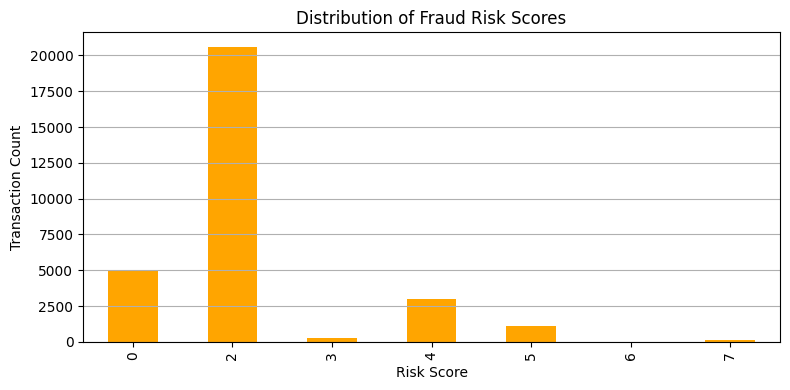

In [1528]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
df['risk_score'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title("Distribution of Fraud Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Transaction Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Chart Insight: Fraud Risk Score Distribution**

This bar chart visualizes how many transactions fall under each fraud risk score.  
Higher scores represent combinations of multiple suspicious signals (e.g., odd hours, refund abuse, amount spikes, etc.).  

The distribution helps identify how prevalent high-risk behavior is across the dataset, supporting prioritization in further fraud investigation workflows.

# Rule 7: Output High-Risk Users  
Objective: Export a table of users with a risk score ≥ 5 for downstream investigation.

In [1529]:
import os
os.makedirs("data", exist_ok=True)

high_risk.to_csv("data/high_risk_users.csv", index=False)


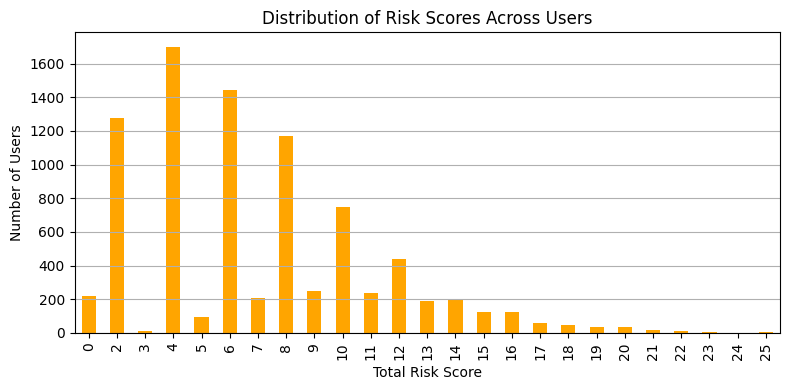

In [1530]:
# average risk score per user
user_scores = df.groupby('user_id')['risk_score'].sum()

plt.figure(figsize=(8, 4))
user_scores.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title("Distribution of Risk Scores Across Users")
plt.xlabel("Total Risk Score")
plt.ylabel("Number of Users")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Chart insight:**  
this chart shows the most at-risk users based on the cumulative fraud indicators (e.g. spikes, refunds, odd hours).  
users with higher scores should be prioritized for investigation.

# SUMMARY
This notebook implements 7 fraud detection rules using Python, pandas, SQL, and data visualization.  
Each rule flags behavior patterns that may signal suspicious user activity.

Output files are saved for further investigation or integration into an alert pipeline:
- High-frequency transactions  
- Odd-hour activity  
- Refund-heavy users  
- Shared device usage  
- Amount spikes  
- Composite risk scores  
- High-risk user table